Create an input file, read or generate the corresponding netcdf simulation file in our database and create a simple plot

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import simplesimdb as simplesim # this one is our own database manager
import subprocess # to capture errors from the simulations
import yaml
import pandas as pd

First let us inspect the database class for an overview of how it works

In [2]:
help(simplesim)

Help on module simplesimdb:

NAME
    simplesimdb - Creation and management of simple simulation data

CLASSES
    builtins.object
        Manager
        Repeater
    
    class Manager(builtins.object)
     |  Manager(directory='./data', filetype='nc', executable='./execute.sh')
     |  
     |  Lightweight Simulation Database Manager
     |  
     |  Create, access and display simulation data of a given code as pairs
     |  (inputfile.json : outputfile [, restarted_01, restarted_02, ...]),
     |  where all input is given by python dictionaries (stored as json files)
     |  and the output files (of arbitrary type) are generated by an executable
     |  that takes the json file as input. This executable is provided by the user.
     |  
     |  NOTE: an executable may only take one sinlge input file and may only
     |      generate one single output file (except for RESTART, see below)
     |  NOTE: the executable can be a bash script. For example if the actual program
     |     

Now, let us generate an input file for impurities_hpc.
Read more about the various parameters in the corresponding impurities.pdf documentation

In [3]:
# BE CAREFUL: the inputfile should be very strict on input types,
# i.e. 
# DO NOT WRITE 3.0 INTO A FIELD REQUIRING AN INTEGER
# AND VICE VERSA 10 INTO A FIELD REQUIRING A FLOAT
# else our database manager will treat it as a new entry
inputfile={
    "grid" :
    {
        "n"  : 3,
        "Nx" : 128,
        "Ny" : 128,
        "x" : [0, 200],
        "y" : [0, 200]
    },
    "output":
    {
        "type" : "netcdf",
        "tend" : 1500,
        "maxout" : 50,
        "n"  : 3,
        "Nx" : 64,
        "Ny" : 64
    },
    "elliptic":
    {
        "stages" : 3,
        "eps_pol" : [1e-6, 0.5, 0.5],
        "eps_gamma" : [1e-8, 1, 1],
        "direction" : "forward"
    },
    "timestepper":
    {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-6,
        "atol" : 1e-7,
        "reject-limit" : 2
    },
    "curvature" : 0.000457,
    "potential":
    {
        "epsilon_D" : 0,
        "bc" : ["DIR", "PER"]
    },
    "species":
    [
        {
            "name" : "e",
            "mu" : 0,
            "tau" : -1,
            "a" : -1,
            "nu_perp" : 0, # 1e-5
            "bc" : ["DIR", "PER"],
            "init":
            {
                "type" : "zero_potential"
            }
        },
        {
            "name" : "i",
            "mu" : 1,
            "tau" : 0.0,
            "a" : 0.999,
            "nu_perp" : 0, # 1e-5
            "bc" : ["DIR", "PER"],
            "init":
            {
                "type" : "blob",
                "amplitude" : 1,
                "posX" : 0.5,
                "posY" : 0.5,
                "sigma" : 10,
                "flr" : "gamma_inv"
            },
        },
        {
            "name" : "j",
            "mu" : 2,
            "tau" : 0.0,
            "a" : 0.001,
            "nu_perp" : 0, # 1e-5
            "bc" : ["DIR", "PER"],
            "init":
            {
                "type" : "blob",
                "amplitude" : 1,
                "posX" : 0.5,
                "posY" : 0.5,
                "sigma" : 10,
                "flr" : "gamma_inv"
            }
        }
    ]
}

Create a Database in the data folder

In [4]:
m = simplesim.Manager(directory='data', executable='./execute.sh', filetype='nc')
# Let's see what id the database allocates to our input
print(m.jsonfile(inputfile))

data/d44f8877562eafa2df602adb66c81d5d5ebc8da2.json


Now we have to either run the simulation or simply read the output data if it is already available in our data base

In [5]:
# Takes about a minute ...
ncfile=m.create(inputfile, error = "display")
print( ncfile)

Running simulation d44f88...bc8da2.nc
data/d44f8877562eafa2df602adb66c81d5d5ebc8da2.nc


Let's print the metadata in the netcdf file to see what is inside

In [6]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
time (51,)
y (192,) 	y-coordinate in Computational coordinate system
x (192,) 	x-coordinate in Computational coordinate system
n_e (51, 192, 192) 	Real density in 2d for species e
gy_e (51, 192, 192) 	Gyro-center density in 2d for species e
psi_e (51, 192, 192) 	Gyro-center potential for species e
vor_e (51, 192, 192) 	Gyro-center vorticity for species e
S_e (51, 192, 192) 	 a_s tau_s N ln N for species e
U_e (51, 192, 192) 	 0.5 a_s mu_s N u_E^2 for species e
n_i (51, 192, 192) 	Real density in 2d for species i
gy_i (51, 192, 192) 	Gyro-center density in 2d for species i
psi_i (51, 192, 192) 	Gyro-center potential for species i
vor_i (51, 192, 192) 	Gyro-center vorticity for species i
S_i (51, 192, 192) 	 a_s tau_s N ln N for species i
U_i (51, 192, 192) 	 0.5 a_s mu_s N u_E^2 for species i
n_j (51, 192, 192) 	Real density in 2d for species j
gy_j (51, 192, 192) 	Gyro-center density in 2d for species j
psi_j (51, 192, 192) 	Gyro-center potential for species j
vor_j (51, 

Now we can plot the content. (MW: Maybe investigate why for n=3 the blob looses its up-down symmetry and for n=4 it does not)

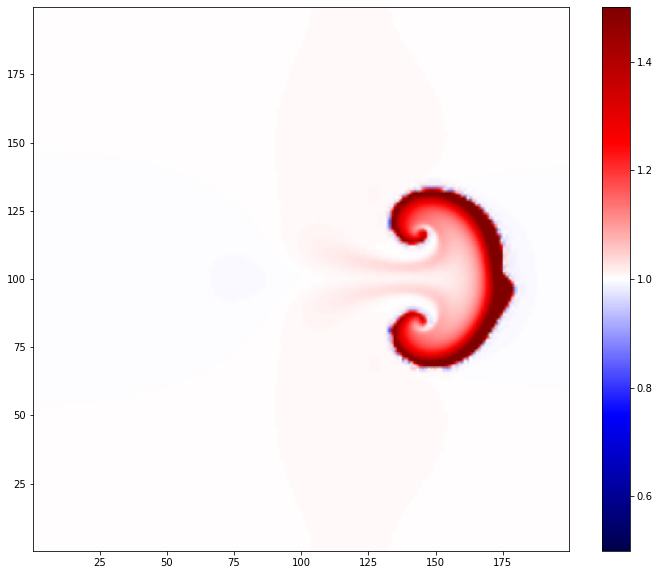

In [7]:
ncin = Dataset( ncfile, 'r', format="NETCDF4")
xc = ncin["xc"][:,:]
yc = ncin["yc"][:,:]
vo = ncin["n_e"][:,:,:]
po = ncin["psi_e"][:,:,:]
time = ncin["time"][:]
plt.figure(figsize=(12, 10))
plt.pcolormesh(xc,yc,vo[-1,:,:],
               shading='gouraud',
               cmap = 'seismic', vmin = 0.5, vmax = 1.5 )
plt.colorbar()
#plt.axis('scaled')
plt.show()

0.05208862183435109


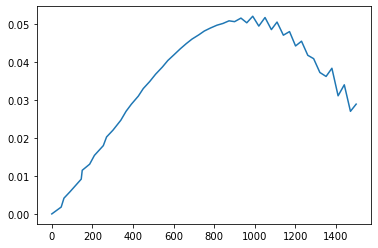

In [8]:
#  plot center of mass velocity
weights= ncin["weights"][:,:]
xc = ncin["xc"][:,:]
yc = ncin["yc"][:,:]
time = ncin["time"][:]
n_e = ncin["n_e"][:,:,:]

total_blob_mass = np.sum( (n_e-1)*weights, axis=(1,2) )
com = np.sum( (n_e-1)*xc*weights, axis=(1,2))/total_blob_mass

# Compute foward differences of com to get com velocity

deltat = np.diff(time)
vel = np.diff( com)/deltat
vel = np.append( 0, vel)

# plot
# plt.plot( time, com )
plt.plot( time, vel )
print( max(vel))

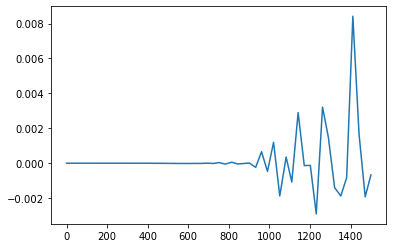

In [9]:
S_e = ncin["S_e"][:,:,:]
S_i = ncin["S_i"][:,:,:]
U_e = ncin["U_e"][:,:,:]
U_i = ncin["U_i"][:,:,:]

total_energy = np.sum( (S_e + S_i + U_e + U_i)*weights, axis=(1,2) )

# plot accuracy of energy
plt.plot( time, (total_energy[0]-total_energy)/total_energy[0])

In [10]:
# Analyse performance of simulations
outfiles = simplesim.Manager(directory='data', executable='./execute.sh', filetype='out')

In [11]:
outfile = outfiles.outfile( inputfile)
output = yaml.full_load(open(outfile))
# print( output)
df = pd.json_normalize(output['timeloop'])
df.set_index('time',inplace=True)
df.tail()

,gammaNe,gammaNi,gammaNj,pol,psie,psii,psij,rhse,rhsi,rhsj,total
time,,,,,,,,,,,
1499.48,0.000031,0.000028,0.000027,0.163627,0.000071,0.000027,0.000027,0.000152,0.000150,0.000145,0.164369
1499.95,0.000031,0.000028,0.000028,0.127408,0.000079,0.000028,0.000028,0.000151,0.000144,0.000145,0.128174
1499.97,0.000031,0.000029,0.000028,0.015103,0.000070,0.000027,0.000027,0.000152,0.000144,0.000144,0.015837
1499.99,0.000031,0.000029,0.000028,0.005119,0.000071,0.000027,0.000027,0.000152,0.000144,0.000142,0.005849
1500,0.000031,0.000028,0.000029,0.005086,0.000072,0.000028,0.000027,0.000152,0.000154,0.000157,0.005845


In [12]:
dff = df.drop('total',axis=1)
# df['total'].mean()
dff.mean() / df['total'].mean()

gammaNe    0.000323
gammaNi    0.000288
gammaNj    0.000286
pol        0.992049
psie       0.000730
psii       0.000281
psij       0.000283
rhse       0.001551
rhsi       0.001465
rhsj       0.001467
dtype: float64